**Lab 4**

Problem 1

1)
We are gong to be looking at a large dataset this week of 25 million rows
Lets first import it

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
from scipy import optimize

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,3)

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')


In [4]:
hf.keys()

<KeysViewHDF5 ['data']>

In [5]:
data = np.array(hf.get('data'))
data[1]

array([315.        , 315.00711228, 315.01422457, ..., 345.31910877,
       345.32622105, 345.33333333])

In [6]:
hf.close

<bound method File.close of <HDF5 file "gammaray_lab4.h5" (mode r)>>

In [7]:
Data = pd.DataFrame({'time':data[0], 'Solar phase' : data[1] , 'Earth phase':data[2], 'particle counts':data[3]})

Now let’s look through the data to find a way to model the background, we have data for particle count in a 100 millisecond window as well as meta data for the earth phase and solar phase

Looking at the particle counts vs time graph we see some periodic counts lets look to see if this could have somthhing to do with the earth or the solar phases

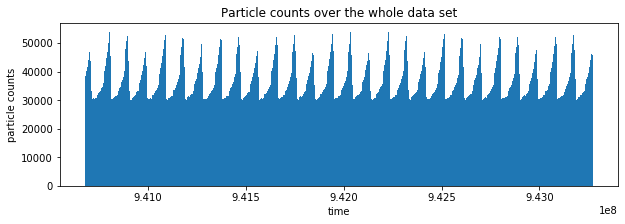

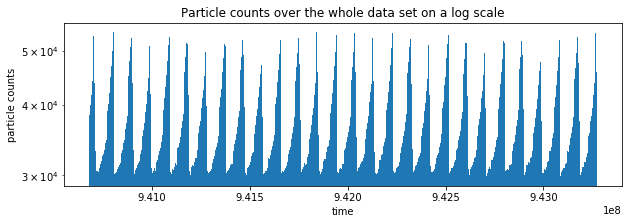

In [8]:

plt.hist(Data['time'],weights=Data['particle counts'], bins=5000)
#plt.yscale('log')
plt.xlabel('time')
plt.ylabel('particle counts')
plt.title('Particle counts over the whole data set')
plt.show()

plt.hist(Data['time'],weights=Data['particle counts'], bins=5000)
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('particle counts')
plt.title('Particle counts over the whole data set on a log scale')
plt.show()

Below we can see that there really is not a corilations of the particl counts to the solar phase

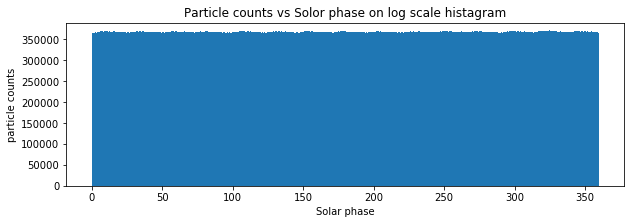

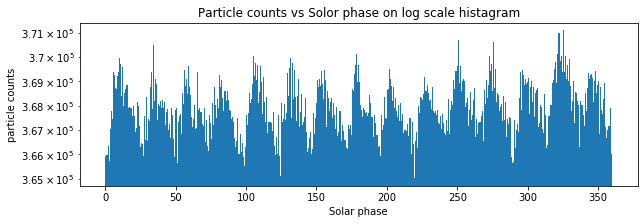

In [9]:
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

#plt.yscale('log')
plt.show()
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

plt.yscale('log')
plt.show()

Now when looking at the partcle counts vs the earth phase we see a nice ditsrbuint this is going to be how we make the background

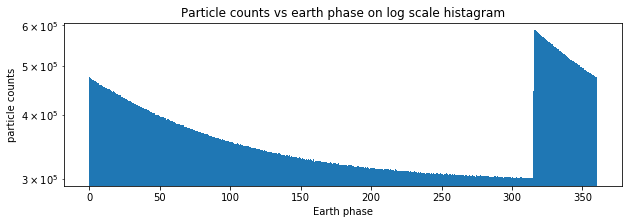

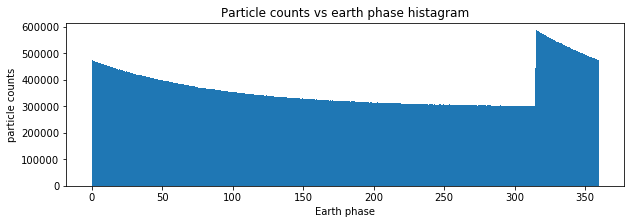

In [10]:
plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase on log scale histagram')
plt.show()

plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
#plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase histagram')
plt.show()

Lets make sure that the phase changes consitatly over time since we are going to want to find a time depence for the phase

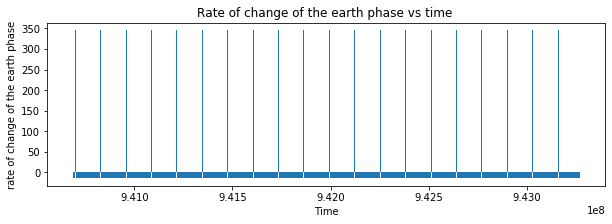

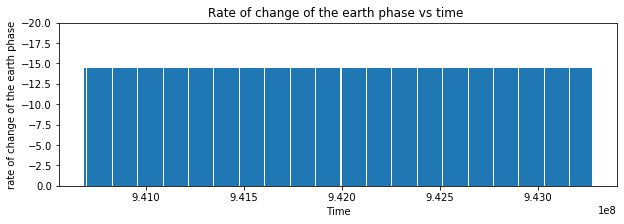

In [11]:
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.xlabel('Time')
plt.title('Rate of change of the earth phase vs time ')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.show()
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.title('Rate of change of the earth phase vs time ')
plt.xlabel('Time')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.ylim([0,-20])
plt.show()

Looking at the data we see signal contamination that has a depence on the earths phase. Now to get a background we will find the depencence of the partial count to the earth phase. That will give us an avarage count that we can use to build a poission backgound ditribution to then use to find signifgance of signals. Befor that we need to make sure that we have enough data points at each phase to get an accreut mean, if not we willa vrage over a few degrees, which will be an issre right at the jump of the particl count. Sence we have 430 oribts in our data we dont have to avrage the mean and can just caluclate the mean at some phase. 

In [39]:
Data.nunique()

time               25920001
Solar phase        25920001
Earth phase          327040
particle counts          31
dtype: int64

2)
So the we expect the background to be poisson ditubuted we just needt find a mean for it. To find the mean for a phase we filter our data so we just have the mesurment formt he same earth phase and then mean the counts. we then use that mean to model out backgroudn. Now once we have a way to go from earth phase to mean we can easly go from time to mean since earth phase as a ocnssitnce change vs time. But we can also jsut look at the metta data and can pull out the earth pase at any time.

3) now we can model the background data at any time let do it for a few taimes to show how close the midel is to the data, we jsut eant to look at data taken at the same earth phase. 

In [ ]:
def backgroundmodelplot(n):
    #n=1099000

    D = Data[(Data["Earth phase"] < Data.at[n+1,'Earth phase'])]
    D = D[(D["Earth phase"] >= Data.at[n,'Earth phase'])]
    
    mu=D.mean()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5,label = 'Model of background')
    plt.xlim([0,25])
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,label =  'Background of the data')
    plt.yscale('log')
    plt.title('Particle count frequency background at earth phase={0:1.6f} on a semilog graph'.format(Data.at[n,'Earth phase']))
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5, label = 'Model of background')
    #plt.matplotlib.pyplot.step(x,stats.poisson.pmf(x,mu[3],loc=0))
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,align='left',label = 'Background of the data')
    plt.xlim([0,25])
    plt.ylabel('Frequncy')
    plt.title('Particle count frequency background at earth phase={0:1.6f}'.format(Data.at[n,'Earth phase']))
    plt.xlabel('Particle count')
    plt.legend()
    plt.show()
    
    len(D

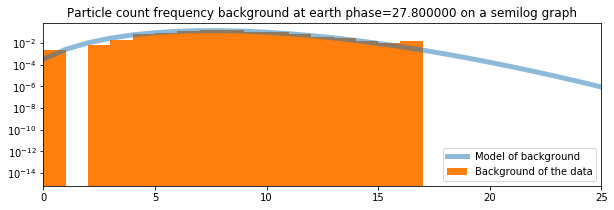

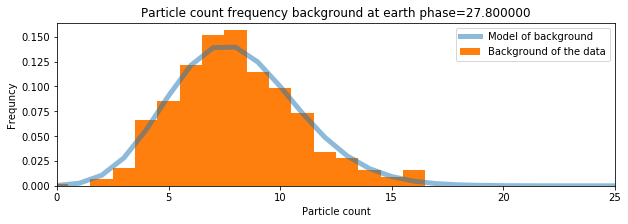

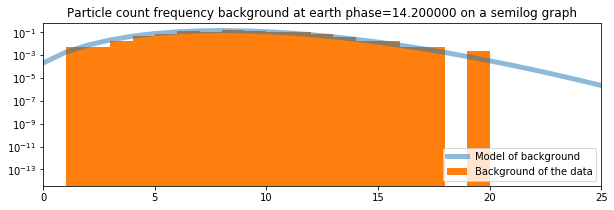

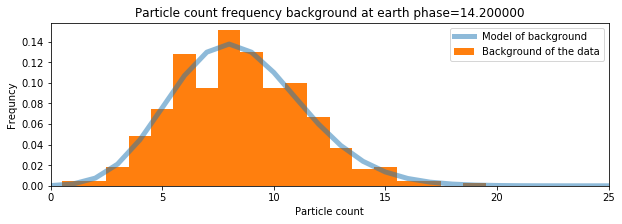

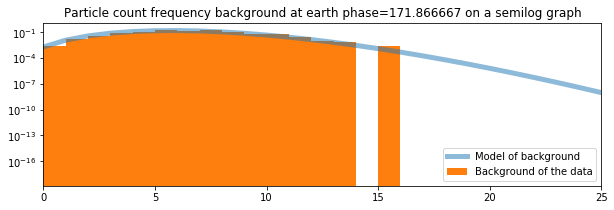

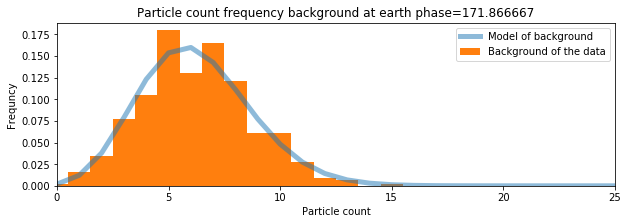

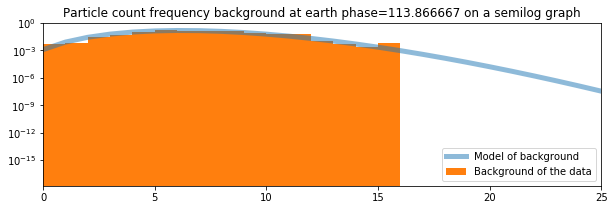

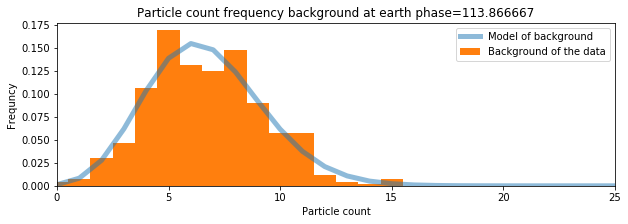

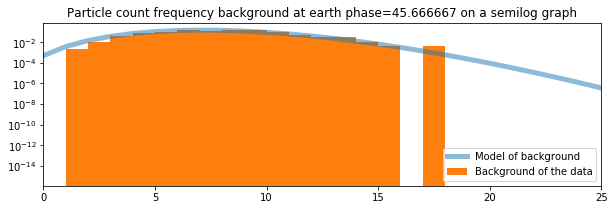

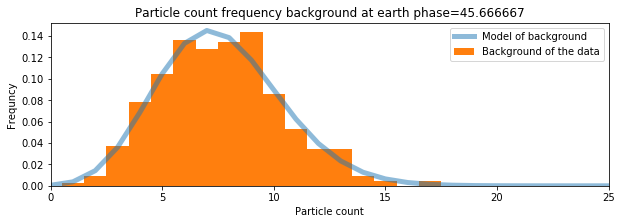

In [74]:
backgroundmodelplot(13983420)
backgroundmodelplot(49380)
backgroundmodelplot(1099030)
backgroundmodelplot(10330)
backgroundmodelplot(100)

We particularly care about how well the tails fits the data which can be seen on the log graph. since we are only doing 430 points of data we get a cutoff in the counts next we will avage over a small range of phases to get a lager datat set to compar to our modle

In [93]:
def backgroundmodelplotspread(n):
    #n=1099000

    D = Data[(Data["Earth phase"] < Data.at[n+15,'Earth phase'])]
    D = D[(D["Earth phase"] >= Data.at[n-15,'Earth phase'])]
    
    mu=D.mean()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5,label = 'Model of background')
    plt.xlim([0,25])
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,label =  'Background of the data')
    plt.yscale('log')
    plt.title('Particle count frequency background at earth phase={0:1.6f} plus and minuse 0.2 degrees on a semilog graph'.format(Data.at[n,'Earth phase']))
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5, label = 'Model of background')
    #plt.matplotlib.pyplot.step(x,stats.poisson.pmf(x,mu[3],loc=0))
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,align='left',label = 'Background of the data')
    plt.xlim([0,25])
    plt.ylabel('Frequncy')
    plt.title('Particle count frequency background at earth phase ={0:1.6f} plus and minuse 0.2 degrees'.format(Data.at[n,'Earth phase']))
    plt.xlabel('Particle count')
    plt.legend()
    plt.show()
    
    #print(len(D))

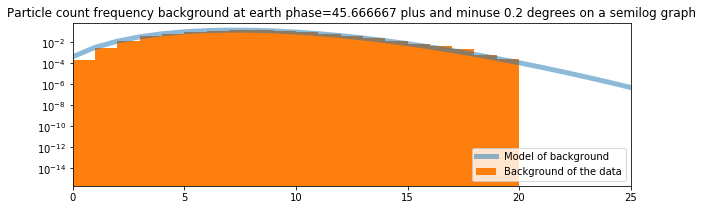

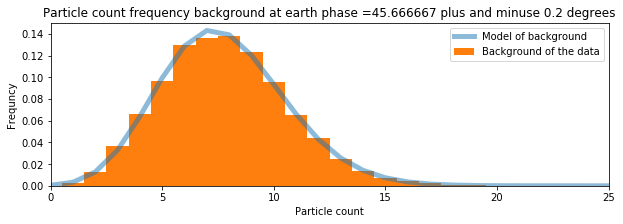

14443


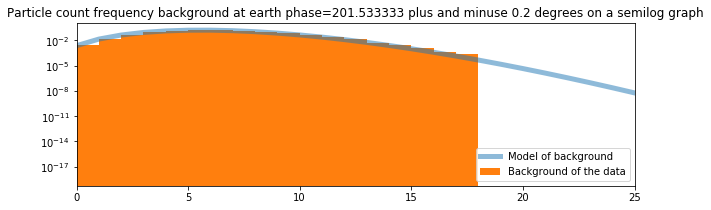

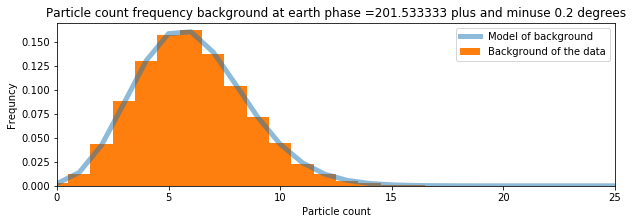

14691


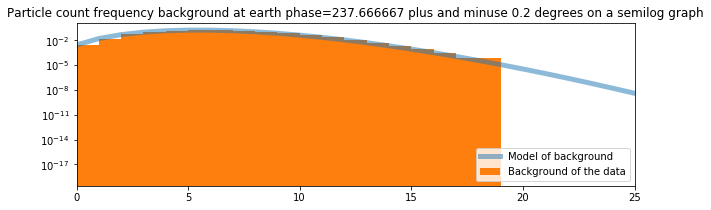

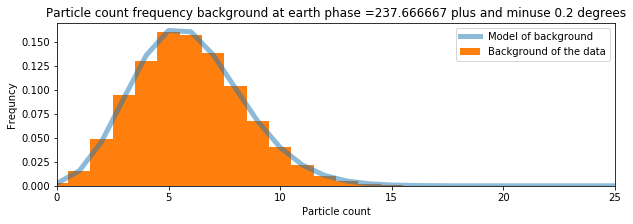

14459


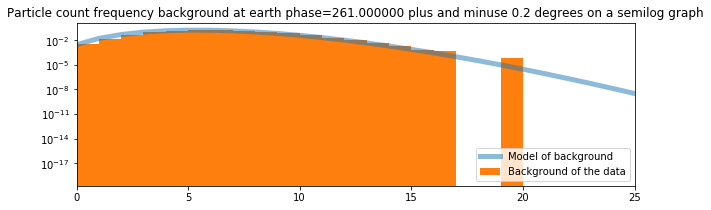

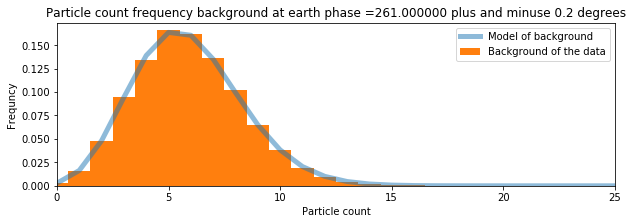

14213


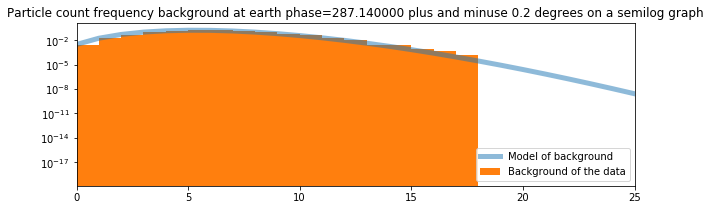

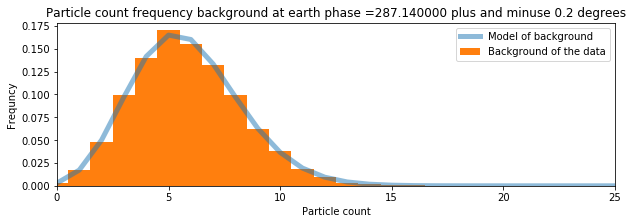

14212


In [95]:
backgroundmodelplotspread(100)
backgroundmodelplotspread(239480)
backgroundmodelplotspread(190900)
backgroundmodelplotspread(32400)
backgroundmodelplotspread(900321)

our modle 

In [ ]:
plt.hist(Data['time'].iloc[0:200000],weights=Data['Earth phase'].iloc[0:200000], bins=1000)
plt.yscale('log')

In [50]:
t = Data['time']
Ep = Data['Earth phase']
Sp = Data['Earth phase']
c = Data['particle counts']